Some random analysis inspired by https://www.bogleheads.org/forum/viewtopic.php?t=272007

Data obtained from https://www.alphavantage.co

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
IDENTITY = lambda x: x
TO_TYPE = lambda t: lambda x: t(x)

def load_asset_data_to_df(
    ticker_name: str,
    fields_loader_lookup={
        "timestamp": TO_TYPE(np.datetime64),
        "close": IDENTITY,
    },
    argumentation_loader_lookup=[
        ("previous_day_close", lambda x: x["close"].shift(periods=1, fill_value=0)),
        ("gain_loss_percentage", lambda x: (x["close"] - x["previous_day_close"]) / x["previous_day_close"]),
        ("std", lambda x: x["gain_loss_percentage"].rolling(20).std()),
        ("inv_std", lambda x: 1 / x["std"])
    ]):
    ticker = pd.read_csv("{}.csv".format(ticker_name))
    # reverse the timeing order
    ticker = ticker.sort_values("timestamp")
    ticker.reset_index(inplace=True, drop=True)
    
    for (k, v) in fields_loader_lookup.items():
        ticker[k] = ticker[k].apply(v)
    for (k, v) in argumentation_loader_lookup:
        ticker[k] = v(ticker)

    return ticker

In [3]:
def trim_timeframe(dfs):
    lower_bound = np.max([df["timestamp"].min() for df in dfs])
    upper_bound = np.min([df["timestamp"].max() for df in dfs])
    
    for df in dfs:
        df.drop(df[df["timestamp"] < lower_bound].index, inplace=True)
        df.drop(df[df["timestamp"] > upper_bound].index, inplace=True)

In [4]:
def trim_nans(df):
    for c in df.columns.values:
        df.drop(df[df[c].isnull()].index, inplace=True)

In [5]:
assets_to_hold = ["SSO", "UBT"]

In [6]:
tickers = {x: load_asset_data_to_df(x) for x in assets_to_hold}
for t in tickers.values():
    trim_nans(t)
trim_timeframe(tickers.values())
for t in tickers.values():
    t.reset_index(inplace=True, drop=True)

In [7]:
def find_eq_volatility_allocation(tickers):
    df = pd.DataFrame()
    df["timestamp"] = list(tickers.values())[0]["timestamp"]
    df["total_volatility"] = list(tickers.values())[0]["inv_std"] * 0
    
    for t in tickers.values():
        df["total_volatility"] = df["total_volatility"] + t["inv_std"]
    
    for k, v in tickers.items():
        df["{}_weight".format(k.lower())] = v["inv_std"] / df["total_volatility"]
    return df

In [8]:
allocation = find_eq_volatility_allocation(tickers)

/home/rmeng/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


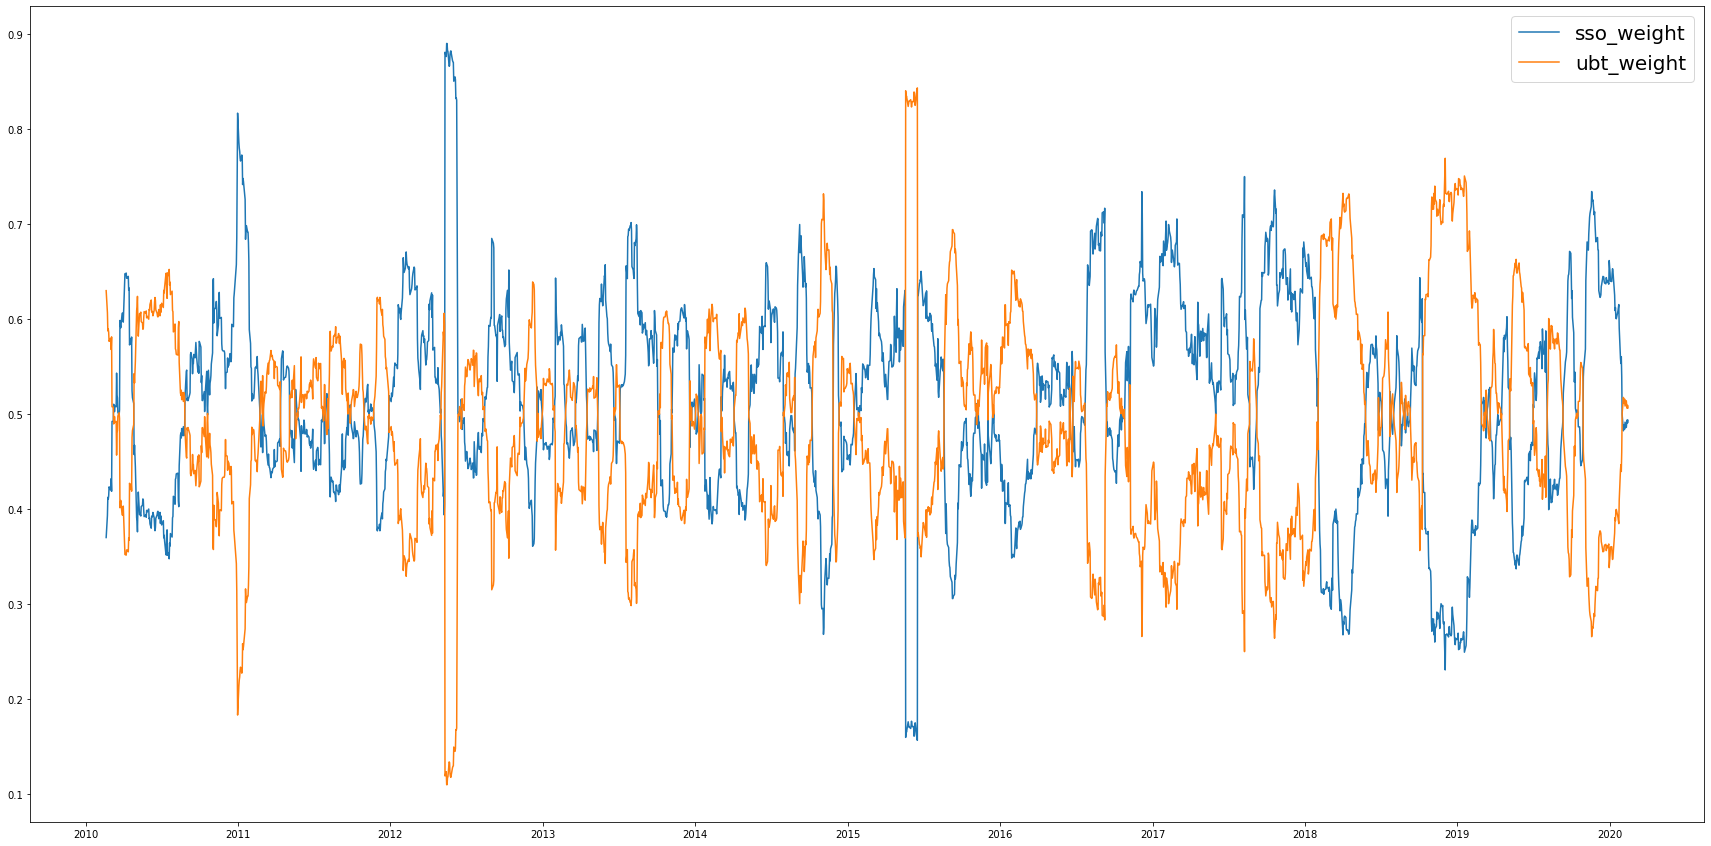

In [9]:
plt.rcParams['figure.figsize'] = [30, 15]

for x in allocation.columns.values:
    if x == "total_volatility" or x == "timestamp":
        continue
    plt.plot(allocation["timestamp"], allocation[x], label=x)

plt.legend(prop={'size': 20})

In [10]:
allocation[allocation["timestamp"] > np.datetime64("2020-01-01")]

,timestamp,total_volatility,sso_weight,ubt_weight
2484,2020-01-02,190.715894,0.648680,0.351320
2485,2020-01-03,173.311472,0.639992,0.360008
2486,2020-01-06,172.655561,0.639663,0.360337
2487,2020-01-07,177.605539,0.648123,0.351877
2488,2020-01-08,178.375861,0.653132,0.346868
2489,2020-01-09,176.057836,0.650358,0.349642
2490,2020-01-10,172.101946,0.644084,0.355916
2491,2020-01-13,181.926975,0.625290,0.374710
2492,2020-01-14,184.513939,0.609100,0.390900
2493,2020-01-15,190.581037,0.612195,0.387805
